<a href="https://colab.research.google.com/github/ausaffatima/pneumonia-detection/blob/main/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project aims to build a deep learning model in order to predict pneumonia by looking at the chest x-rays of various people. The dataset is taken from kaggle.

The following lines are used to upload a dataset from kaggle directly into google colab.

In [1]:
'''! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip'''

'! mkdir ~/.kaggle\n! cp kaggle.json ~/.kaggle/\n! chmod 600 ~/.kaggle/kaggle.json\n! kaggle datasets download paultimothymooney/chest-xray-pneumonia\n! unzip chest-xray-pneumonia.zip'

Importing the required libraries

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

Reading and storing the train and test images into the appropriate variables using Image Data Generator from Keras.

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)  # to normalise the data between 0 and 1 for proper
train_set = train_datagen.flow_from_directory('/content/chest_xray/train', 
                                              target_size=(224,224),
                                              batch_size=5216,  # for the 5216 training images
                                              class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('/content/chest_xray/test',
                                           target_size=(224,224),
                                           batch_size=624, # for the 624 testing images
                                           class_mode='categorical')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Converting the ImageDataGenerator object into a numpy array to be able to process furthur.

In [4]:
X_train, y_train = train_set.next()
X_test, y_test = test_set.next()

In [5]:
print(X_train.shape, y_train.shape)

(5216, 224, 224, 3) (5216, 2)


Taking a look at one of the images.

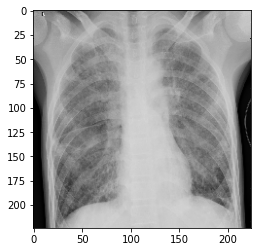

In [6]:
IMG_INDEX = 7   # this value is changed to look at different images
plt.imshow(X_train[IMG_INDEX] ,cmap=plt.cm.binary)
plt.show()

Convolutional Neural Network

Building the base network by stacking convolutional and max pooling layers to extract the features from the images by using relu as the activation function.

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

These extracted features are now flattened and fed to 64 densely connected layers in order to finally classify the image into one of the two classes.

In [9]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)            0

Compiling the model using the adam optimizer and categorical cross entropy loss with accuracy as the metric.

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Fitting the model on our dataset with the number of epochs as 4.

In [12]:
history = model.fit(X_train, y_train, epochs=4, validation_data=(X_test, y_test))

Epoch 1/4
163/163 [==============================] - 41s 100ms/step - loss: 4.1541 - accuracy: 0.7408 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 2/4
163/163 [==============================] - 16s 96ms/step - loss: 4.1439 - accuracy: 0.7429 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 3/4
163/163 [==============================] - 16s 95ms/step - loss: 4.1439 - accuracy: 0.7429 - val_loss: 6.0443 - val_accuracy: 0.6250
Epoch 4/4
163/163 [==============================] - 16s 95ms/step - loss: 4.1439 - accuracy: 0.7429 - val_loss: 6.0443 - val_accuracy: 0.6250


A validation accuracy of 62.5% is observed. We can try to improve this accuracy by using techniques such as data augmentation, transfer learning etc.

Transfer Learning

Loading the base model, MobileNet V2 from Keras. This model has been developed at Google and trained on 1.4 million images.

In [13]:
keras = tf.keras
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

Freezing the base, as we do not want to modify this network furthur. We only have to add on our layers towards the end of this already trained network.

In [15]:
base_model.trainable = False

Setting up the layers that we need to add to this network in order to for it to make predictions for our dataset.


In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [17]:
prediction_layer = keras.layers.Dense(2)

Building and compiling the final model.

In [18]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [19]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Fitting the model on our dataset using 4 epochs.

In [20]:
history = model.fit(X_train, y_train,
                    epochs=8,
                    validation_data=(X_test, y_test))

Epoch 1/8
163/163 [==============================] - 22s 109ms/step - loss: 0.3914 - accuracy: 0.8428 - val_loss: 0.5452 - val_accuracy: 0.7452
Epoch 2/8
163/163 [==============================] - 16s 96ms/step - loss: 0.2713 - accuracy: 0.9410 - val_loss: 1.1214 - val_accuracy: 0.8269
Epoch 3/8
163/163 [==============================] - 16s 101ms/step - loss: 0.2658 - accuracy: 0.9408 - val_loss: 1.0395 - val_accuracy: 0.8478
Epoch 4/8
163/163 [==============================] - 16s 96ms/step - loss: 0.4879 - accuracy: 0.9592 - val_loss: 1.2627 - val_accuracy: 0.8462
Epoch 5/8
163/163 [==============================] - 16s 96ms/step - loss: 0.5558 - accuracy: 0.9638 - val_loss: 1.1805 - val_accuracy: 0.8173
Epoch 6/8
163/163 [==============================] - 16s 97ms/step - loss: 0.3846 - accuracy: 0.9340 - val_loss: 0.9884 - val_accuracy: 0.7965
Epoch 7/8
163/163 [==============================] - 16s 99ms/step - loss: 1.1183 - accuracy: 0.9595 - val_loss: 4.1340 - val_accuracy: 0.81

An improve in accuracy can be observed through transfer learning.